In [2]:
import os, sys

In [3]:
# Check if extracted data folder exists
usingColab = 0
if usingColab:
  if(not os.path.exists('SYSC4415W23_A3_dataset')):

    # Download and extract the dataset if the zip file does not exist
    if (not os.path.isfile('SYSC4415W23_A3_dataset.zip')):
      !wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment3/SYSC4415W23_A3_dataset.zip
      !unzip SYSC4415W23_A3_dataset.zip

else:
  datasetPath = r"C:/Users/googl/Documents/ML/A3_Dataset/SYSC4415W23_A3_dataset"

In [40]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.datasets import load_iris

train_labels = pd.read_csv(f'{datasetPath}/train/labels.csv')
train_features = pd.read_csv(f'{datasetPath}/train/extracted_features.csv')

print(f'number of original features: {train_features.shape}')

# Remove features that have very low variance
sel = VarianceThreshold(threshold=(0.95 * (1 - 0.95)))
trimmed = sel.fit_transform(train_features)
cols = [column for column in train_features.columns 
          if column in train_features.columns[sel.get_support()]]
trimTrainFeat = pd.DataFrame(trimmed, columns=cols)
print(f'Shape after variance threshold of .9525: {trimTrainFeat.shape}')

toDrop = trimTrainFeat.isnull().sum()
for val in range(len(toDrop)):
    if toDrop[val]:
        toDrop[val] = False
    else:
        toDrop[val] = True

dropped = [column for column in trimTrainFeat.columns 
          if column not in trimTrainFeat.columns[toDrop]]
noNaN = trimTrainFeat.drop(columns=dropped)

print(f'Number of reduced features from removing NaN values: {noNaN.shape}')

# Using top 50% of features
nextSel = SelectKBest(score_func=f_classif, k=2700)
trainND = nextSel.fit_transform(noNaN, train_labels['label'])
cols = [column for column in noNaN.columns 
          if column in noNaN.columns[nextSel.get_support()]]
dataset = pd.DataFrame(trainND, columns=cols)
print(f'Feature data shape after SelectKBest using f-value stats: {dataset.shape}')

# Free up memory for next tasks
del trimTrainFeat, toDrop, dropped, trainND, noNaN, cols, trimmed, sel, nextSel


number of original features: (1621, 7048)


C:\Users\googl\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Shape after variance threshold of .9525: (1621, 5424)
(1621, 5403)
Number of reduced features from removing NaN values: (1621, 5403)
Feature data shape after SelectKBest using f-value stats: (1621, 2700)


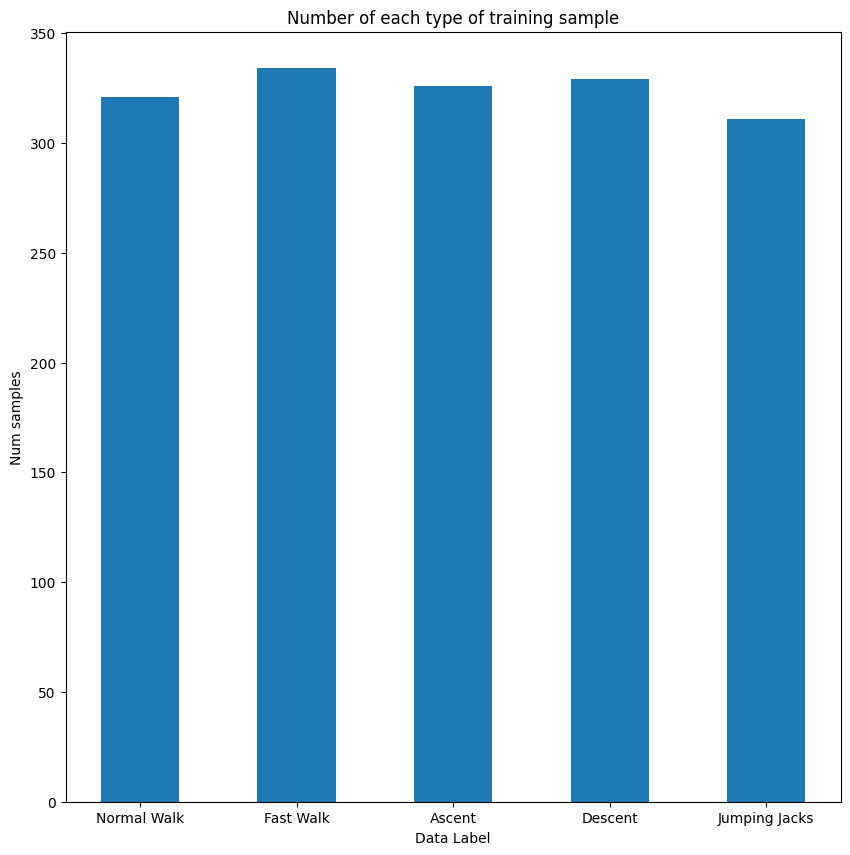

In [41]:
# Data visualization
import matplotlib.pyplot as plt
counts = train_labels.value_counts(subset=['label'])
keys = ['Normal Walk', 'Fast Walk', 'Ascent', 'Descent', 'Jumping Jacks']
vals = [counts[0],counts[1], counts[2], counts[3], counts[4]]

fig = plt.figure(figsize=(10,10))
plt.bar(x=keys, height=vals, width=0.5)
plt.xlabel("Data Label")
plt.ylabel("Num samples")
plt.title("Number of each type of training sample")
plt.show()

# No class imbalance

#### Data Loading and organization

In [55]:
from torch.utils.data import DataLoader
batchSize = 128
tr_split = 1140 # ~70% of labelled data
v_split = 320   # ~20% of labelled data
te_split = 161  # ~10% of labelled data

dataset['label'] = train_labels['label']
dataset = dataset.sample(frac=1) # Shuffle rows before breaking into sets

trainSet = dataset.iloc[:tr_split]                # Shape: 1140, 2700
valSet = dataset.iloc[tr_split:tr_split+v_split]  # Shape: 320, 2700
testSet = dataset.iloc[tr_split+v_split:]         # Shape: 161, 2700

trainL = DataLoader(dataset=trainSet, batch_size=batchSize, shuffle=True)
valL =   DataLoader(dataset=valSet, batch_size=batchSize, shuffle=True)
testL =  DataLoader(dataset=testSet, batch_size=batchSize, shuffle=True)


### Building model
**Hyperparameters**: 
- Learning rate: Using effective LR calculated from base LR using:
$$\eta_{eff} = \frac{B\eta_{base}}{256}$$
- Input size: 2700
- Output size: 5 (1 per class label)
- Hiddel layers: 1
- Nodes/hidden layer: 1800 (2/3 of input size, since input size > num samples)

In [57]:
from sklearn.neural_network import MLPClassifier
lr_base = 0.0001

lr = (batchSize*lr_base)/256
MLP = MLPClassifier((1800,), 'relu', solver='lbfgs', learning_rate_init=lr)

